This notebooks provides an example downstream analysis of a trained MOFA+ model in Python. 

[PBMC10K](https://support.10xgenomics.com/single-cell-gene-expression/datasets) dataset is used as an example, which might be familiar to some of the users of Seurat or scanpy. It is a 3' single-cell RNA sequencing data so only one layer of information (view) is available, that is gene expression.

For this tutorial, only a trained PBMC10k model is needed, and it can be downloaded [here](https://github.com/gtca/mpp/tree/master/data/models/pbmc10k.hdf5).

In [1]:
# Set root folder as a working directory
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

# Connect to the model

In [4]:
! mkdir -p data/models
! wget https://github.com/gtca/mpp/tree/master/data/models/pbmc10k.hdf5

--2019-12-10 19:15:32--  https://github.com/gtca/mpp/tree/master/data/models/pbmc10k.hdf5
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-12-10 19:15:33 ERROR 404: Not Found.



In [6]:
import mpp
m = mpp.mofa_model("data/models/pbmc10k_leiden.hdf5")

This creates a connection to an HDF5 file. According to best practices, it should be closed when the access is not needed anymore by calling `m.close()`.

## Basic model features

We can quickly check the overall dimensions of the model:

In [7]:
print(f"""\
Cells: {m.shape[0]}
Features: {m.shape[1]}
Groups of cells: {', '.join(m.groups)}
Views: {', '.join(m.views)}
""")

Cells: 11537
Features: 217
Groups of cells: 0, 1, 2, 3, 4, 5, 6, 7, 8
Views: rna



The core part of the trained model are 2 matrices: Z (factors) and W (weights, or loadings) matrices. The expectations for Z or W are easily accessible in different formats:

In [8]:
# HDF5 group
print("HDF5 group:\n", m.weights)

# np.ndarray
print("\nnp.ndarray:\n", m.get_weights()[:3,:5])

# pd.DataFrame
print("\npd.DataFrame:\n", m.get_weights(df=True).iloc[:3,:5])

HDF5 group:
 <HDF5 group "/expectations/W" (1 members)>

np.ndarray:
 [[ 3.92751272e-13  1.97243651e-13 -2.23267808e-13 -6.53112667e-14
   5.73123002e-13]
 [ 1.51690487e-12  3.82240162e-13 -1.14801062e-12 -5.60273903e-14
   4.49853473e-13]
 [ 1.91797173e-08 -3.35357150e-10  2.31858522e-09 -5.40470323e-11
  -4.83849211e-10]]

pd.DataFrame:
                 Factor1       Factor2       Factor3       Factor4  \
C1QB       3.927513e-13  1.972437e-13 -2.232678e-13 -6.531127e-14   
LINC00853  1.516905e-12  3.822402e-13 -1.148011e-12 -5.602739e-14   
PDZK1IP1   1.917972e-08 -3.353571e-10  2.318585e-09 -5.404703e-11   

                Factor5  
C1QB       5.731230e-13  
LINC00853  4.498535e-13  
PDZK1IP1  -4.838492e-10  


Same works for factors: try executing `m.factors`, `m.get_factors()`, and `m.get_factors(df=True)`.

The content below is devoted to demonstation of different plotting functions available and is divided into three parts:

1. exploring weights (loadings) of factors,
2. exploring factor values,
3. exploring variance explained by different factors in different groups of cells.

# Plotting weights

Loadings of a factor define a set of features that are important for this factor. In `mpp`, multiple ways to visualise factor loadings are implemented with `matplotlib` and `seaborn` libraries.

Currently the following functions are provided for plottings weights:
- `plot_weights`
- `plot_weights_dotplot`
- `plot_weights_heatmap`
- `plot_weights_scaled`
- `plot_weights_scatter`

## Weights ranked

A visualization of factor weights familiar to MOFA and MOFA+ users is implemented with some modifications in `plot_weights`.

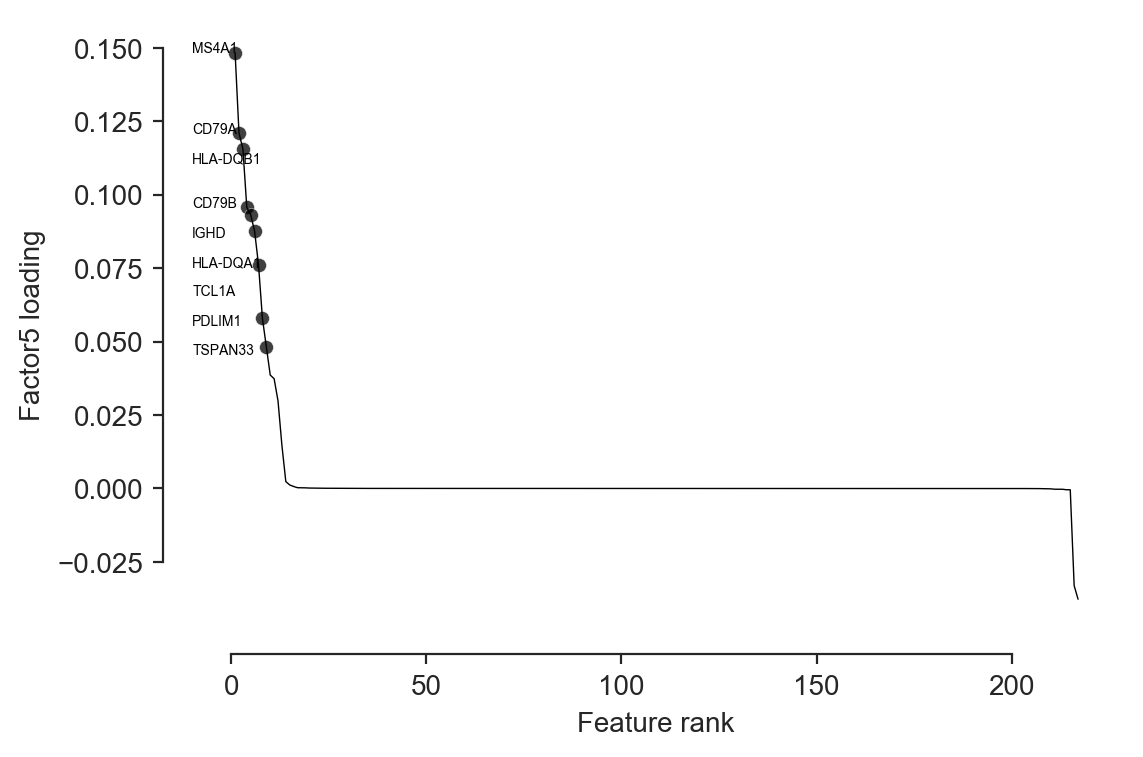

In [9]:
ax = mpp.plot_weights(m, factor=4, n_features=10,
                      y_repel_coef=0.01, x_rank_offset=-10)
# repel coefficient and offsets can be useful to move labels around
# and there are x_rank_offset and x_rank_offset_neg for positive and negative weights respectively

This factor is apparently a B cell-related factor (CD79, CD20 encoded by MS4A1 gene), most probably naïve B cells.

### Customising weights plots

Plots can be further customised using the axis object that is return by plotting functions.

Text(0.5, 1.0, 'B cells factor')

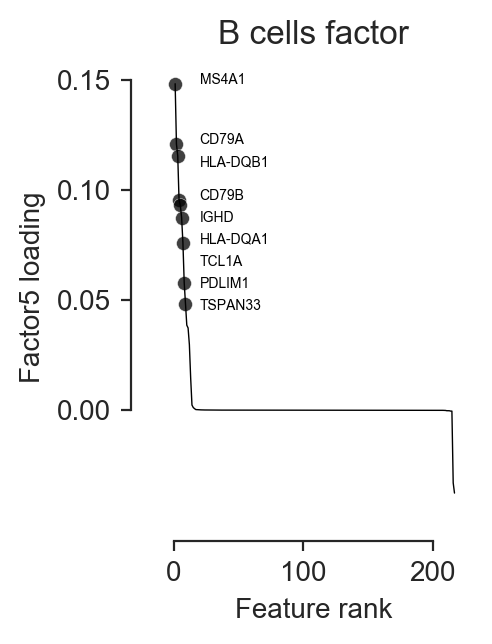

In [10]:
plt.figure(figsize=(2,3))
ax = mpp.plot_weights(m, factor=4, n_features=10,
                      y_repel_coef=0.01, x_rank_offset=20)
ax.set_title("B cells factor")

### Making subplots

When making plots for multiple factors, subplots can be used and an axis can be provided to the `plot_weights` call:

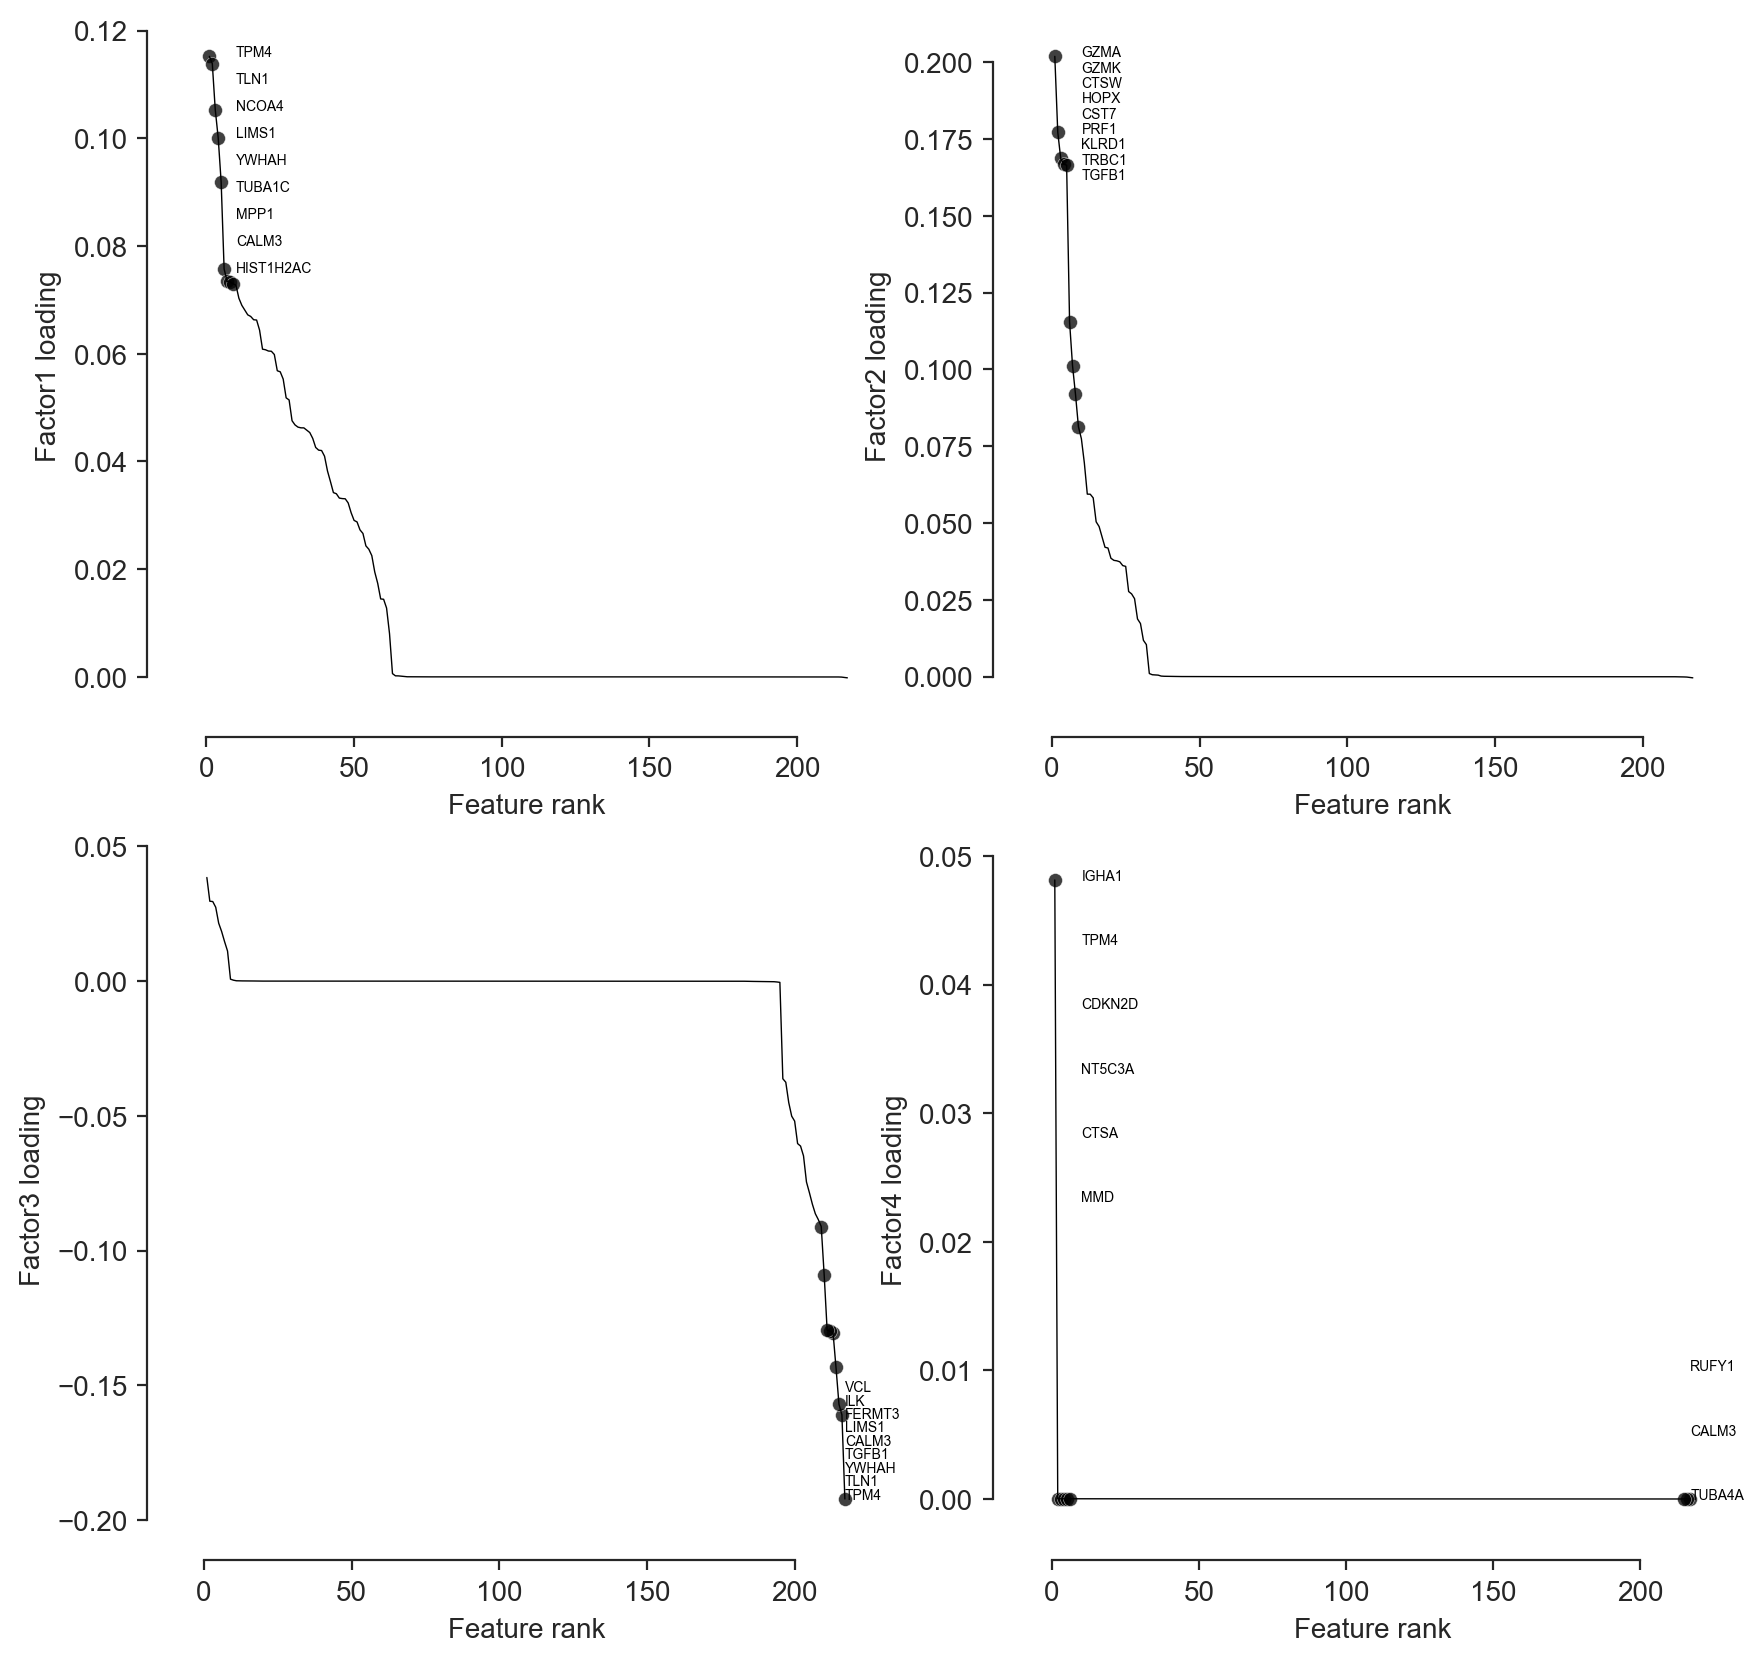

In [11]:
nf = 2  # specify number of rows & columns
f, axarr = plt.subplots(nf, nf, figsize=(10,10))
fnum = 0
for i in range(nf):
    for j in range(nf):
        mpp.plot_weights(m, 
                         # The trick here is to make a plot using a particular axis
                         factor=fnum, ax=axarr[i][j], 
                         n_features=10,
                         y_repel_coef=0.005, attract_to_points=False)
        fnum+=1

## Scaled weights scatterplot

The `plot_weights_scaled` function provides a quick way to plot loadings for 2 factors on one plot. This is one of the common ways of visualizing components/factors loadings in models such as PCA or factor models

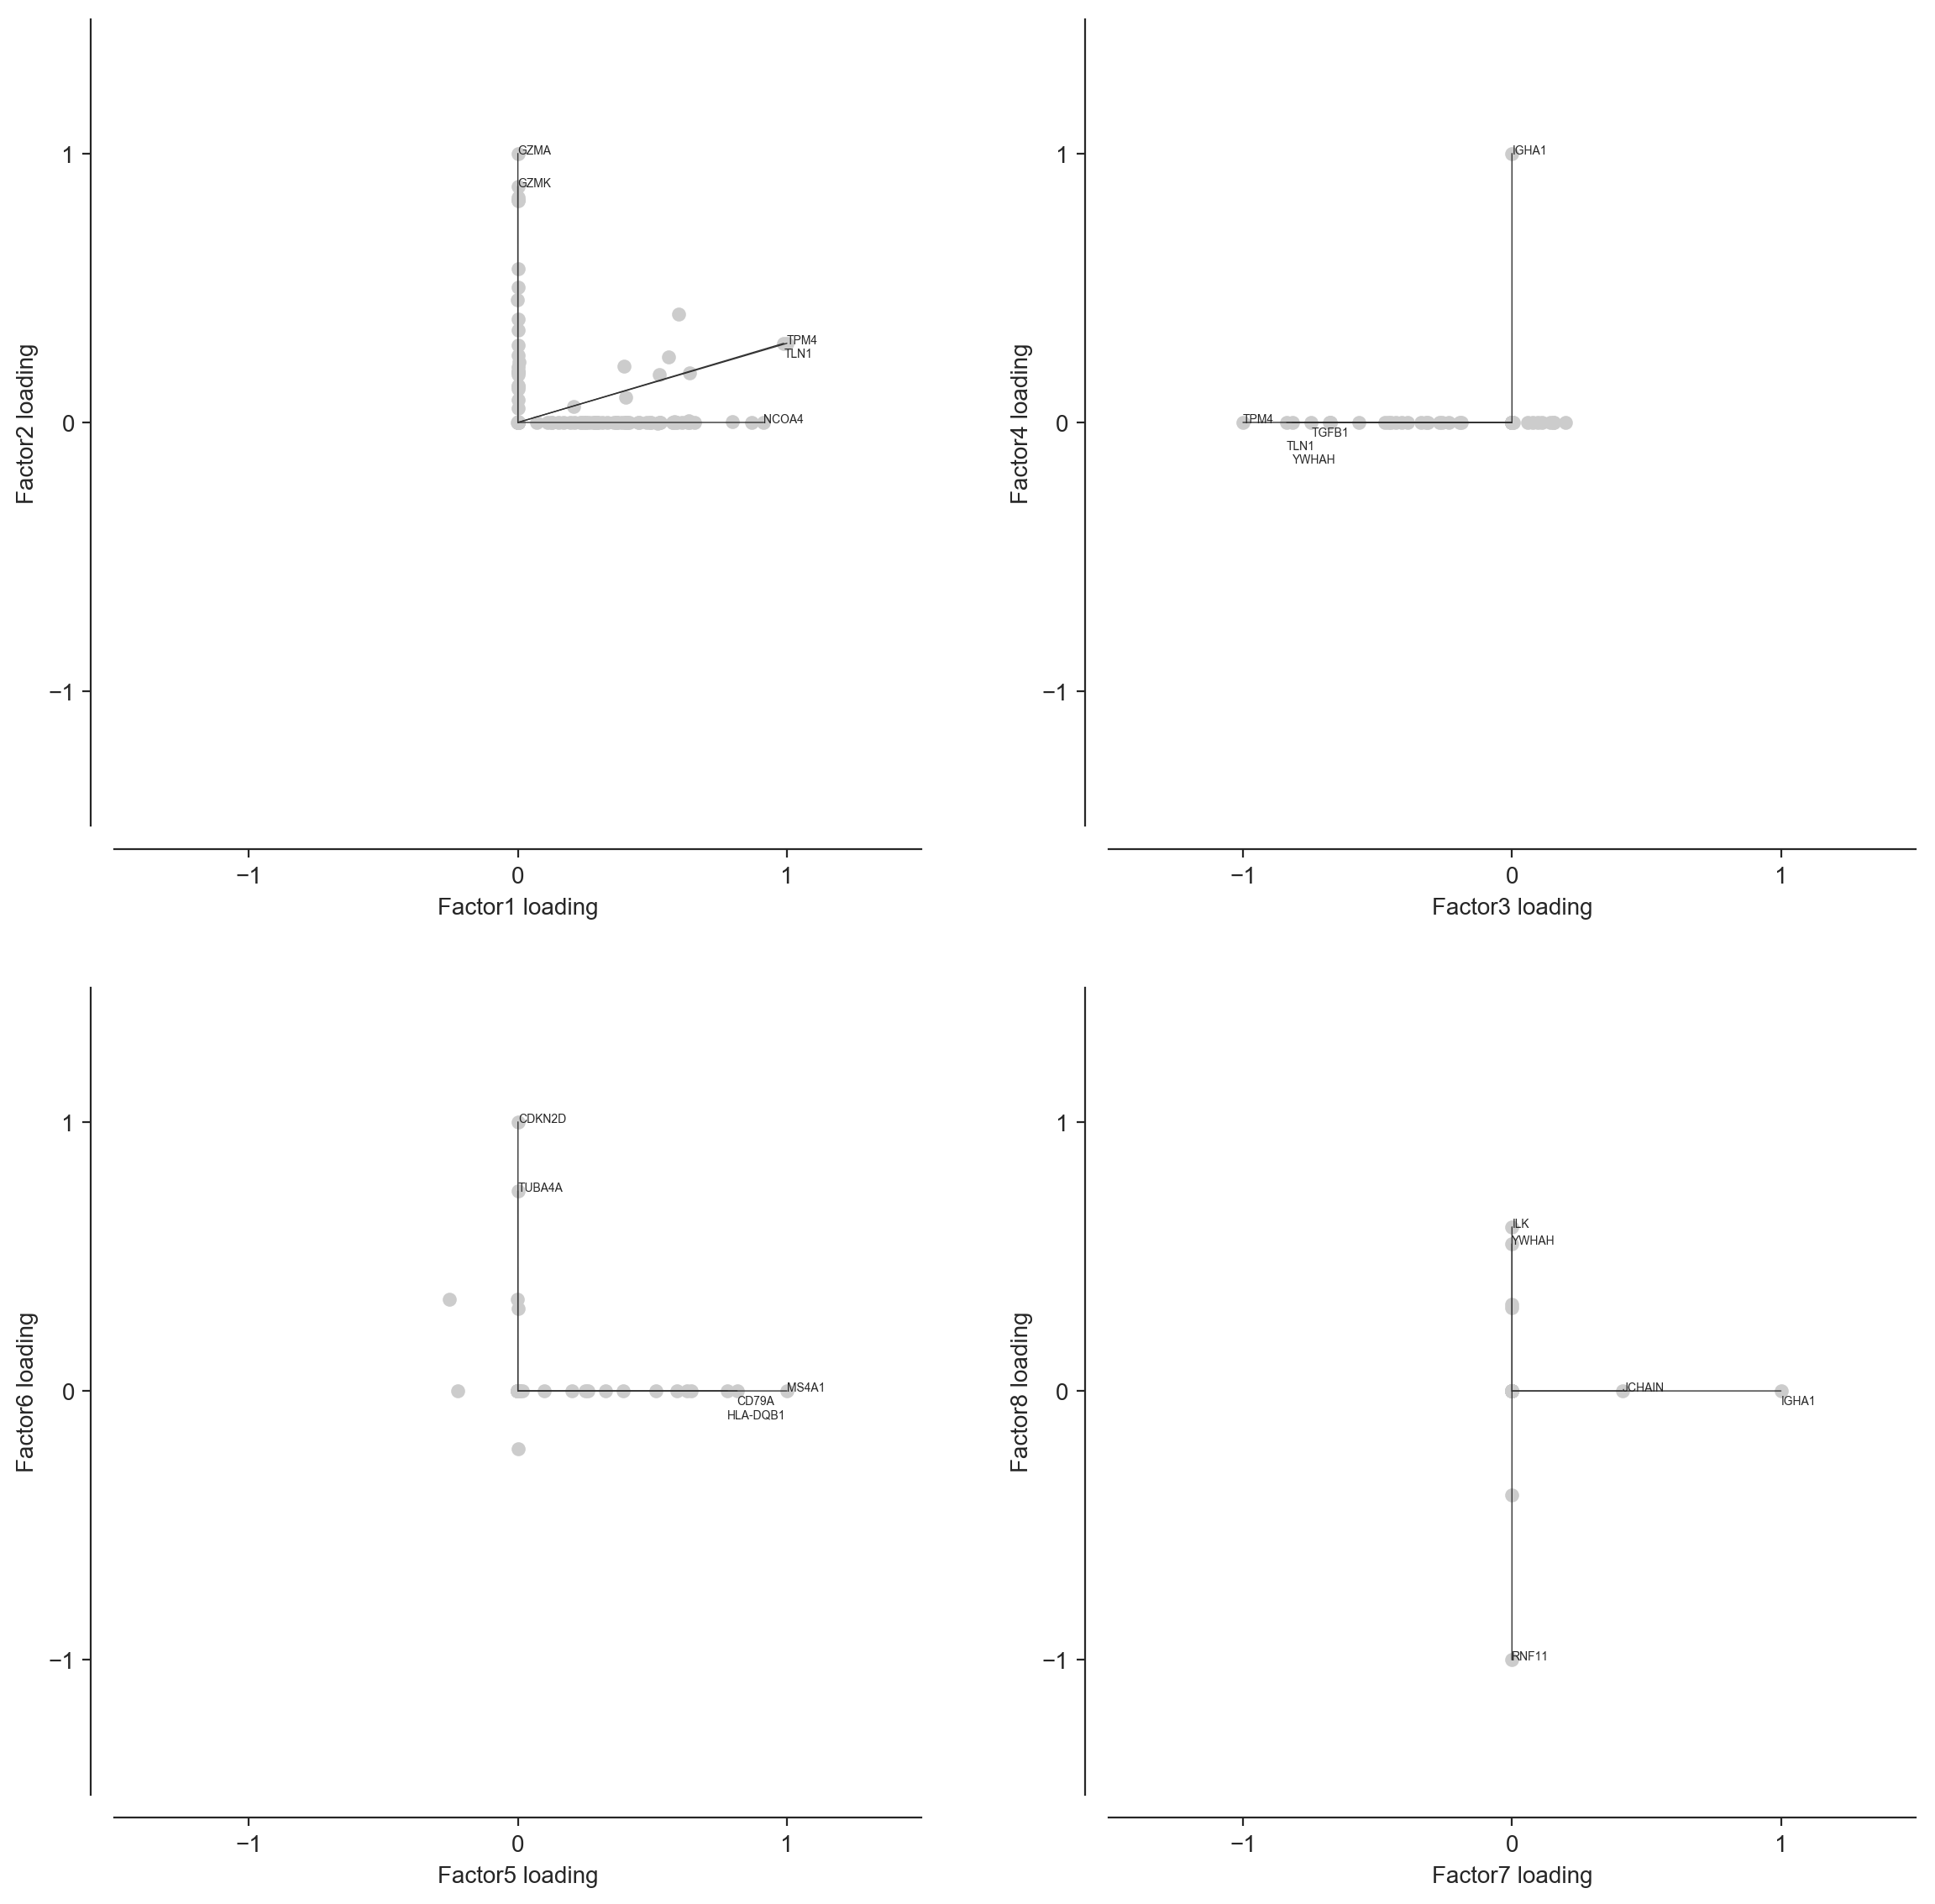

In [12]:
nf = 2
f, axarr = plt.subplots(nf, nf, figsize=(14,14))
fnum = 0
for i in range(nf):
    for j in range(nf):
        mpp.plot_weights_scaled(m, x=fnum, y=fnum+1, n_features=5,
                                ax=axarr[i][j])
        fnum+=2

## Weights scatterplot with marginal

If absolute loadings values are of interest, they can be compared between multiple factors with `plot_weights_scatter`. Marginal distributions can be added with `hist=True` or with `kde=True`.

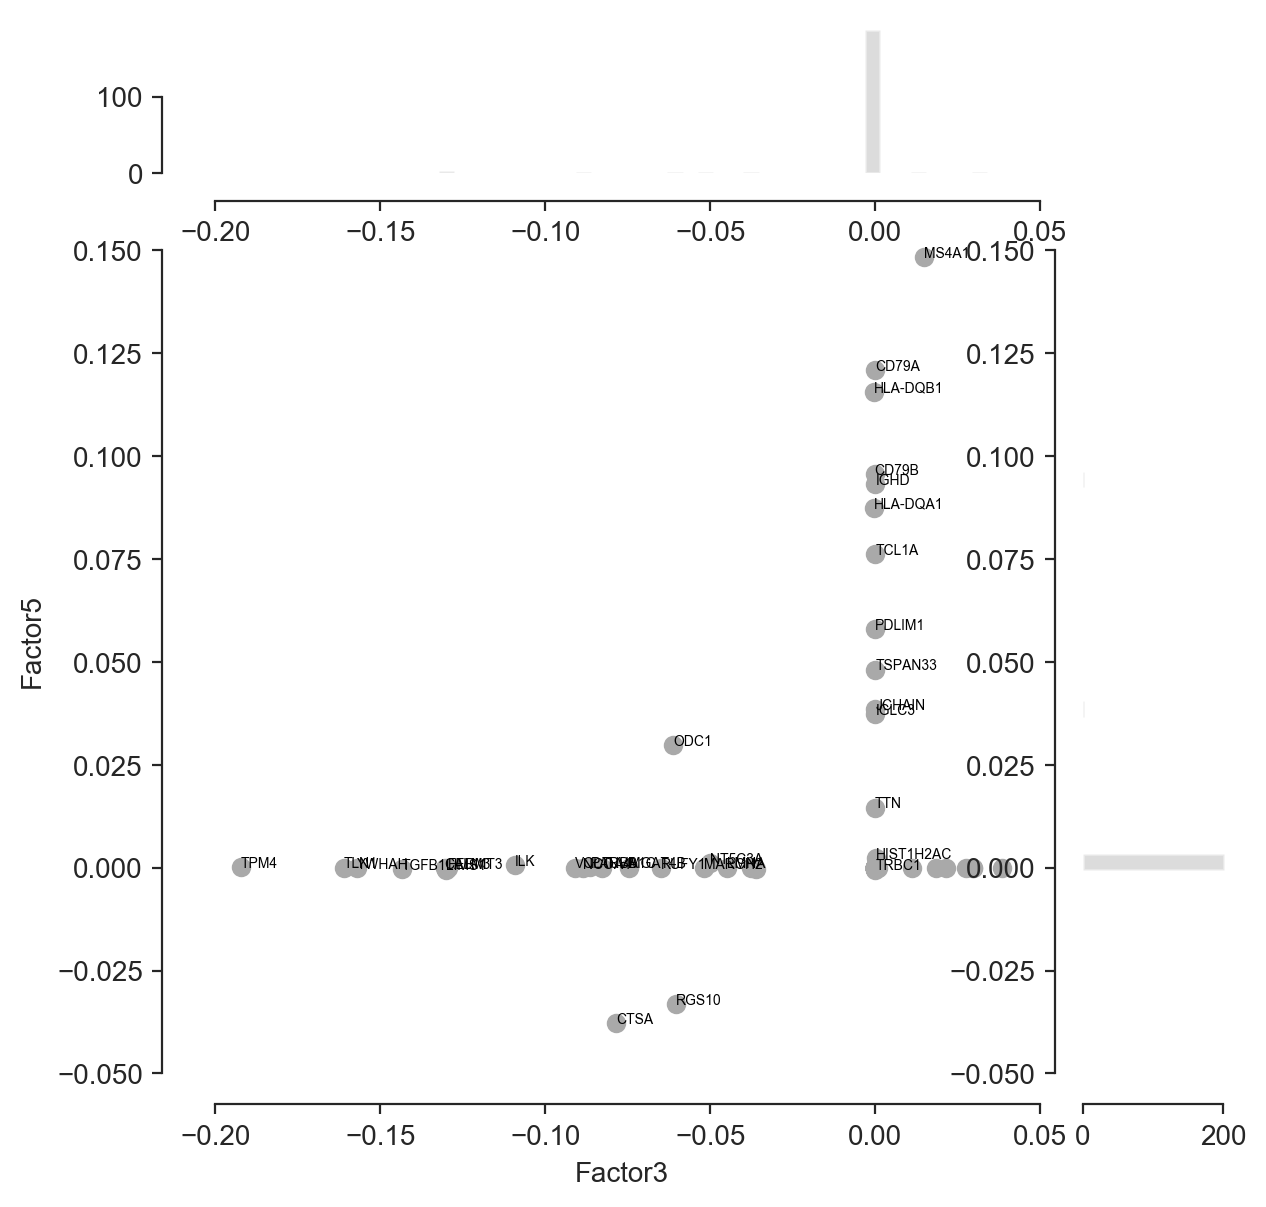

In [13]:
mpp.plot_weights_scatter(m, x="Factor3", y="Factor5",
                         hist=True, n_features=20)

## Weights heatmap

While trying to annotate factors, a global overview of top features defining them could be helpful. 

/usr/local/lib/python3.7/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


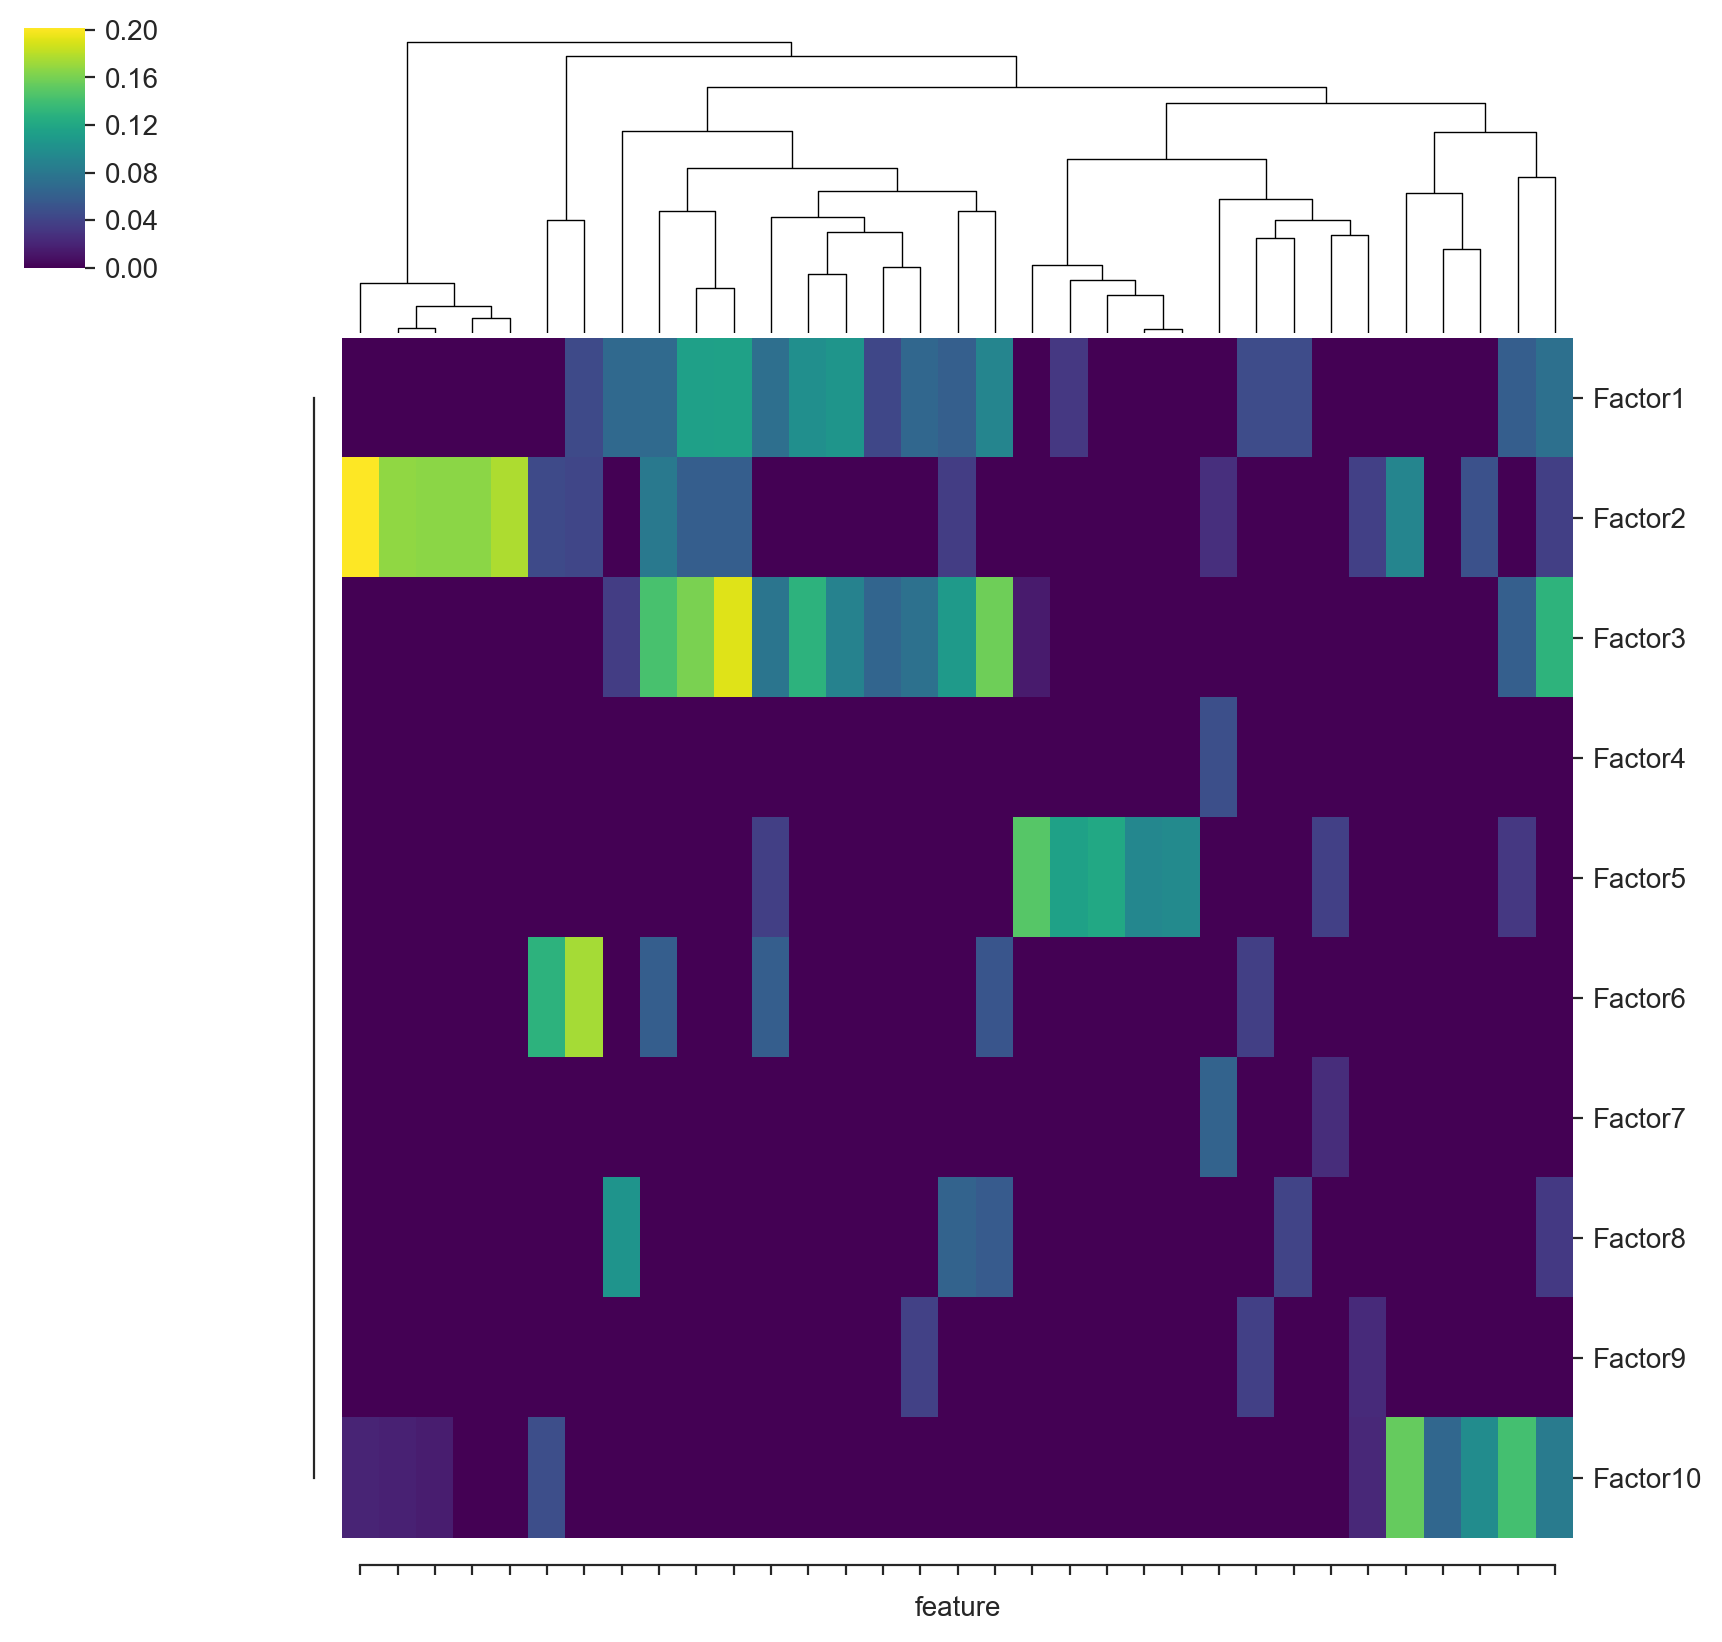

In [14]:
mpp.plot_weights_heatmap(m, n_features=5, 
                         factors=range(0, 10), 
                         xticklabels_size=6, w_abs=True, 
                         cmap="viridis", cluster_factors=False)

Features play a key role on this plot, and to put more emphasis on different types of features (e.g. different cell type markers), each feature can be coloured according to some pattern. E.g. We'll mark HLA genes on that heatmap

In [15]:
features_all = m.get_weights(df=True).index.values
hla_col = ['#007788' if i.startswith("HLA") else '#DDDDDD' for i in features_all]
hla_df = pd.DataFrame({"feature": features_all, 
                       "value": hla_col}).set_index('feature')

hla_df.sort_values("value").head(2)

,value
feature,
HLA-DQB1,#007788
HLA-DQA1,#007788


/usr/local/lib/python3.7/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


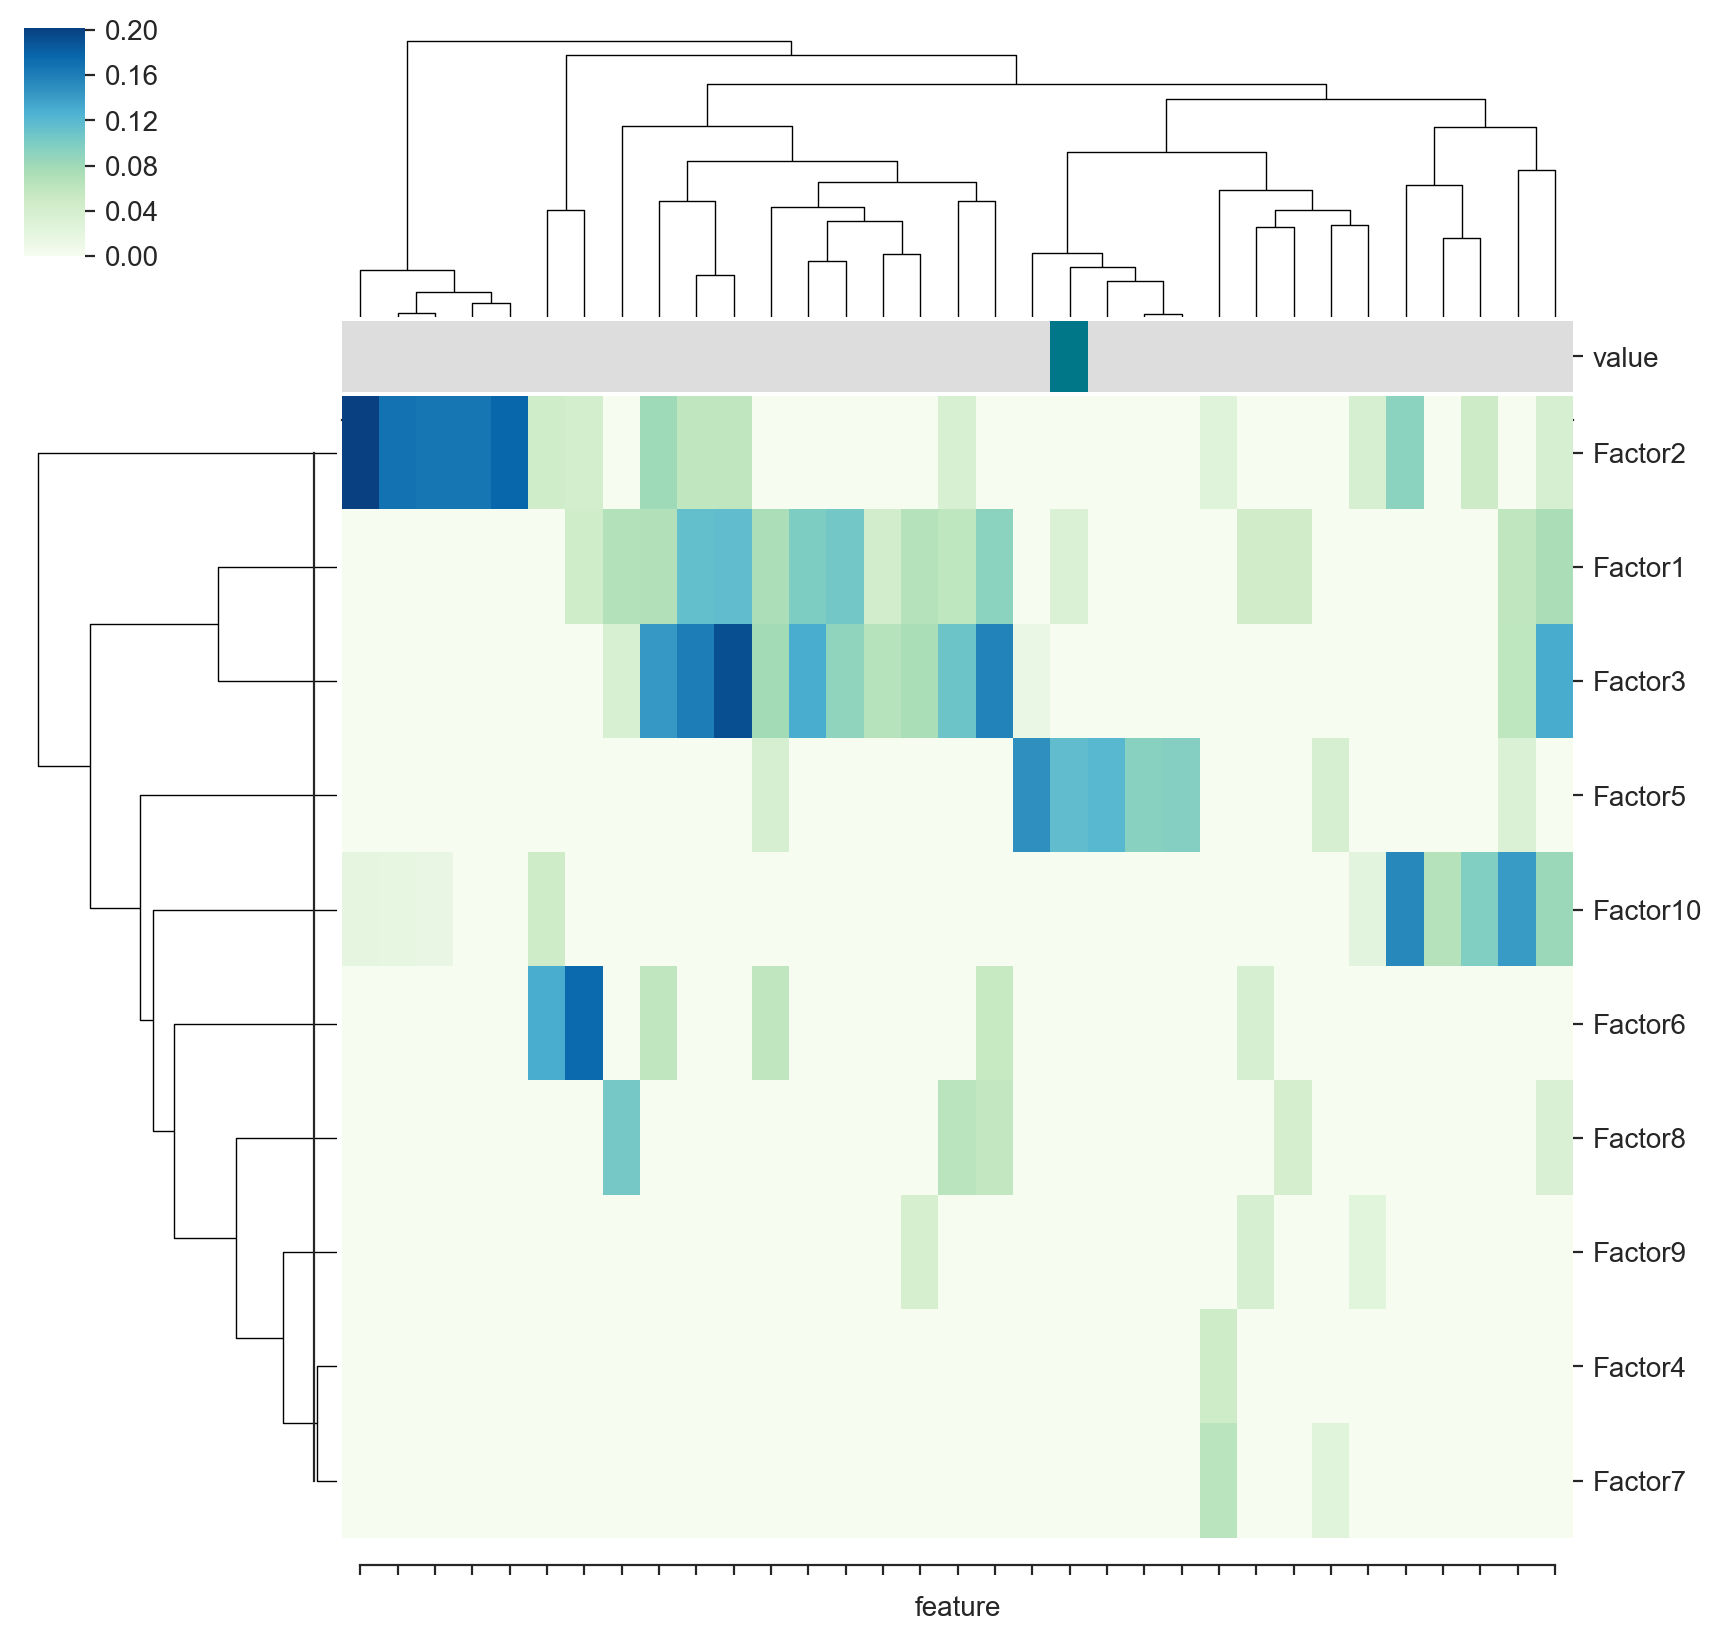

In [16]:
mpp.plot_weights_heatmap(m, n_features=5, 
                         factors=range(0, 10), 
                         features_col=hla_df,
                         xticklabels_size=6, w_abs=True, 
                         cmap="GnBu")

## Weights dotplot

If one wants to rank top features across multiple factors and see how their loadings differ between factors (and how loadings for different features are different for one factor), a dotplot can be useful.

Both absolute loadings or signed ones can be plotted easily (use `w_abs` boolean flag for that).

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


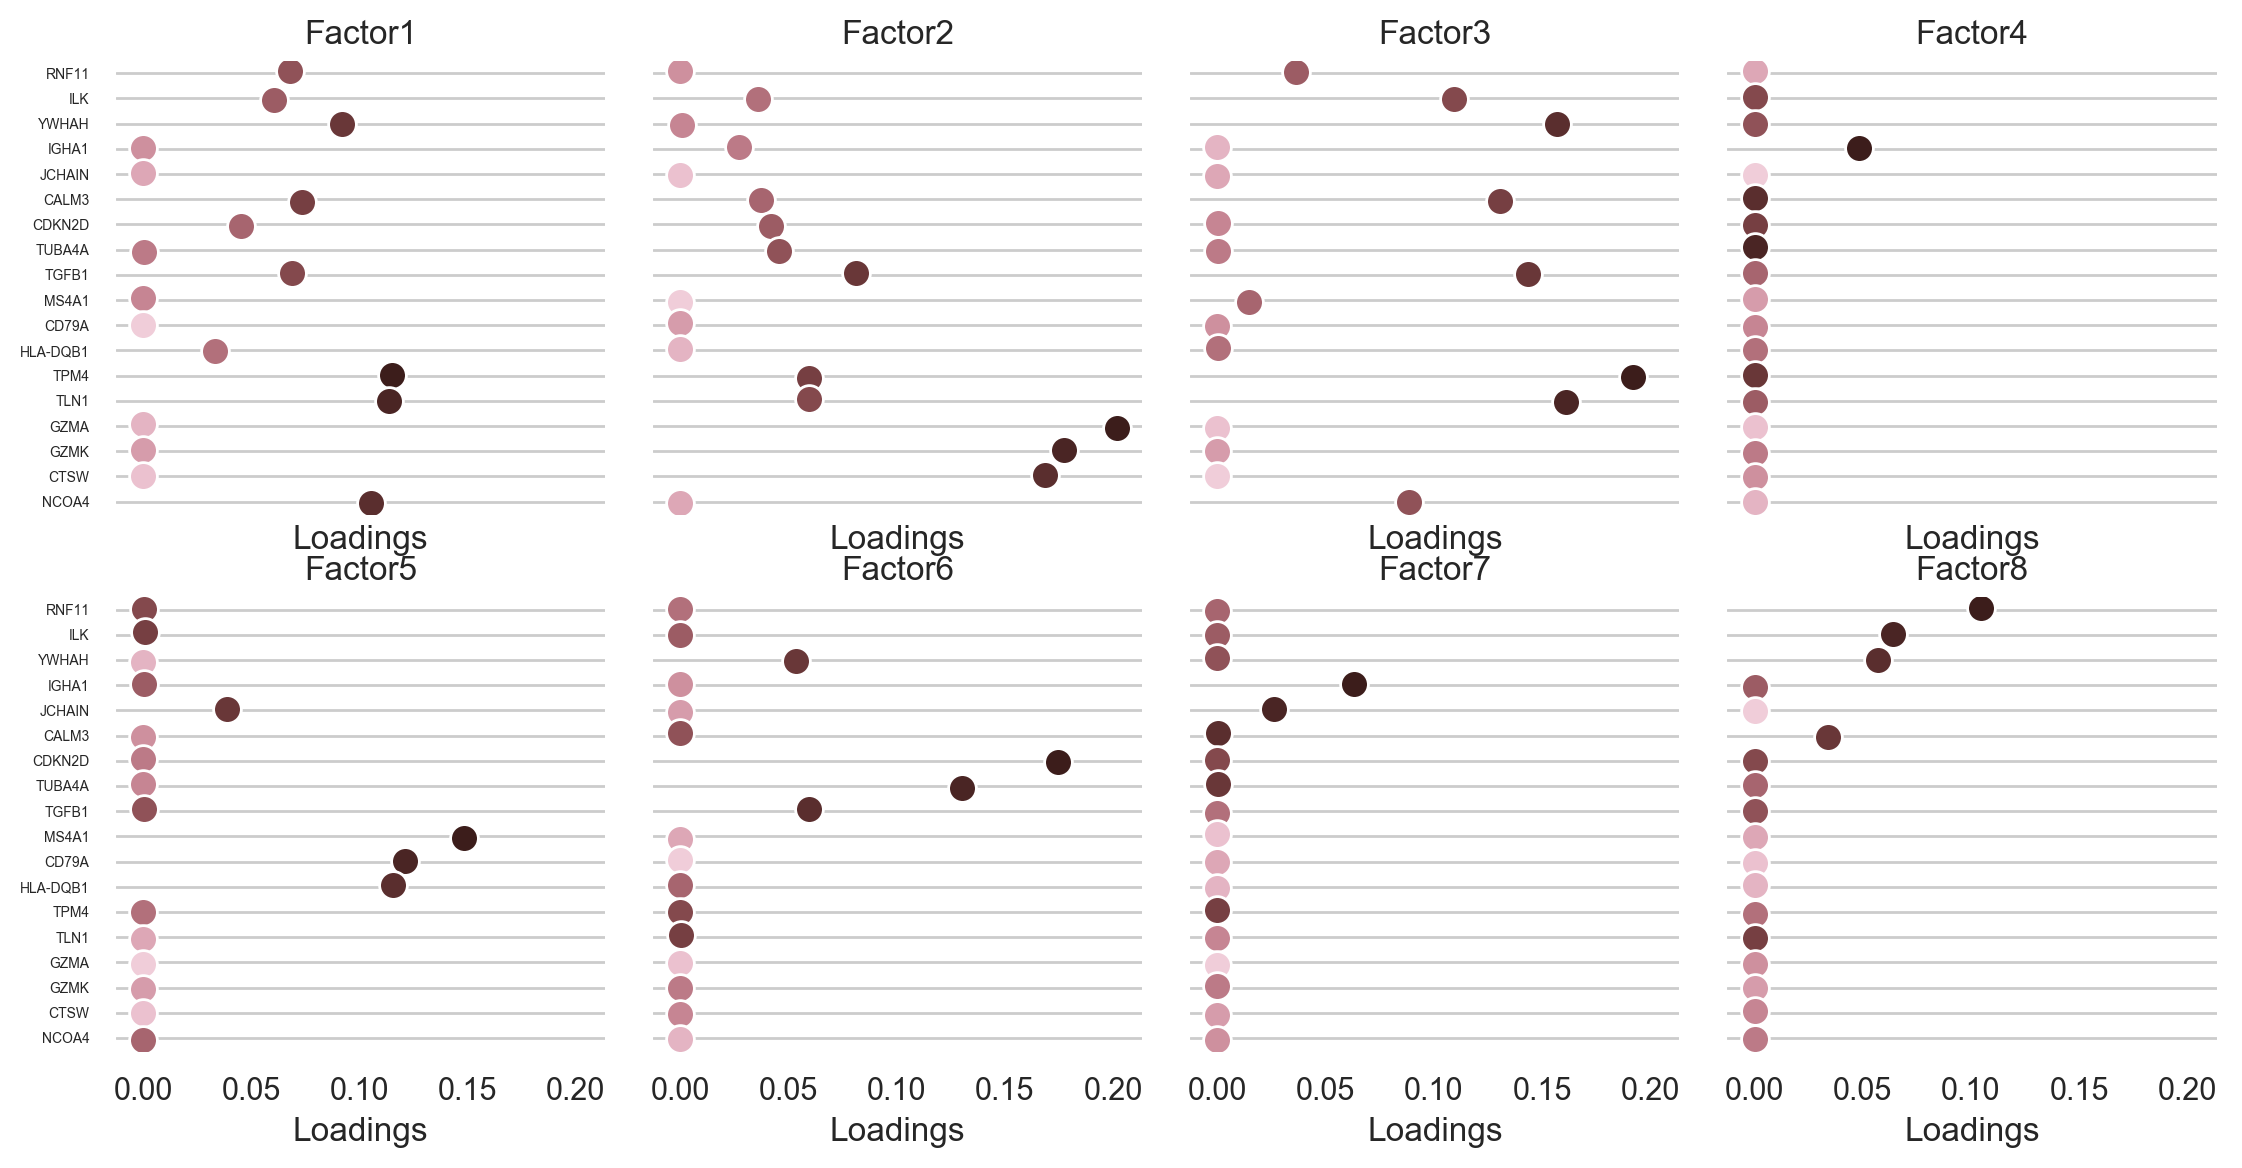

In [17]:
mpp.plot_weights_dotplot(m, n_features=3, 
                         w_abs=True, 
                         factors=list(range(8)), 
                         col_wrap=4, yticklabels_size=5)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


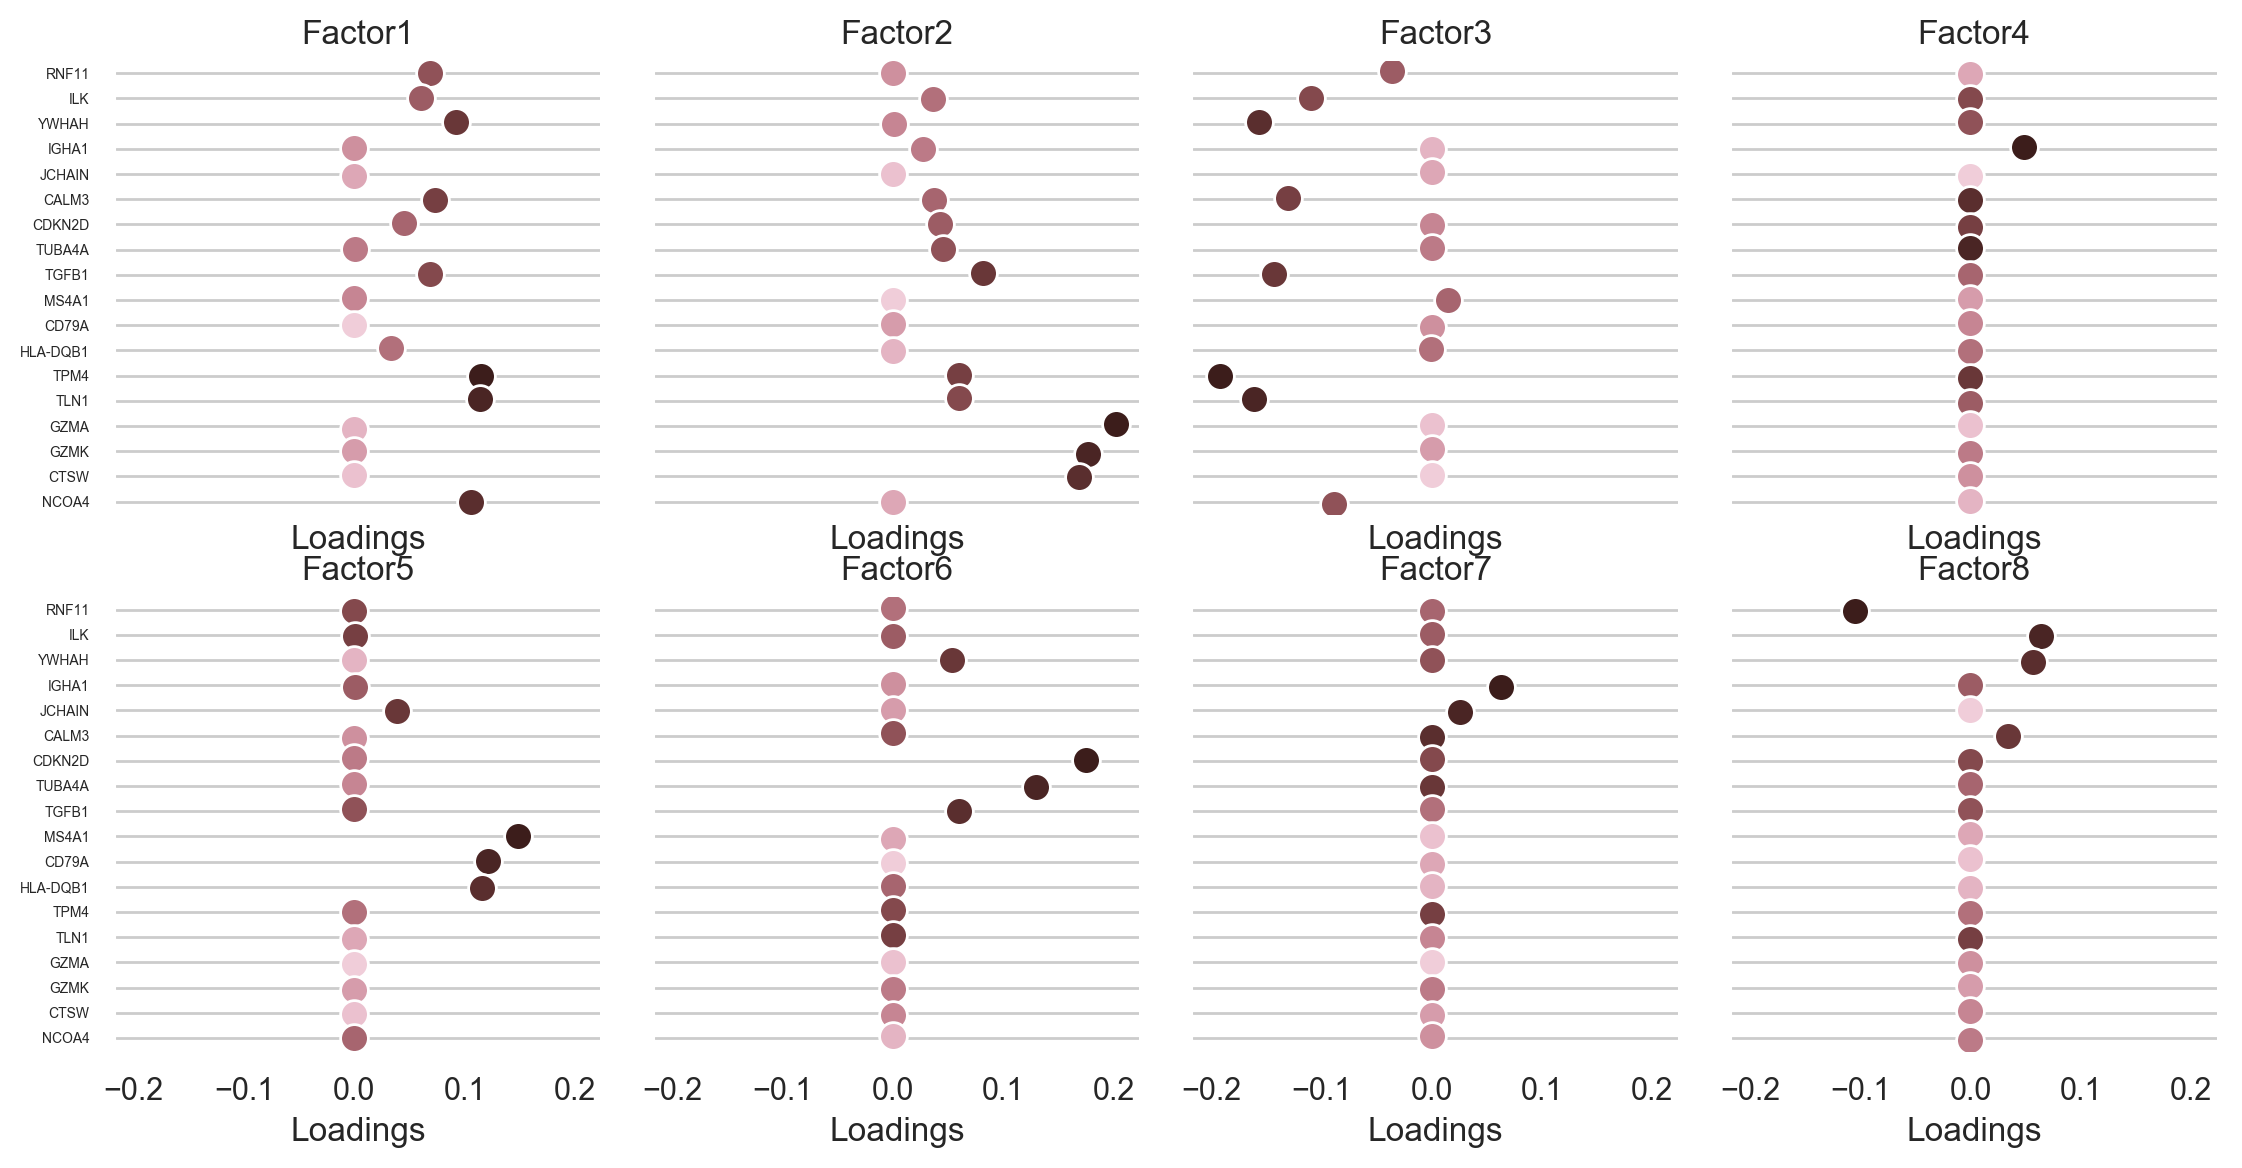

In [18]:
mpp.plot_weights_dotplot(m, n_features=3,  # Number of top features for every factor
                         w_abs=False, 
                         factors=list(range(8)), 
                         col_wrap=4, yticklabels_size=5)

In the latter case, i.e. when using original (not absolute) loadings values, it's easy to see which genes vary in different direction while being important for this factor, e.g. see Factor 8 above.

# Variance explained

One of the key ways to investigate how different sources of variation (factors) very across different views (omics) and groups (groups of cells) is to reconstruct the features times cells matrix, one factor at a time, and to compare it with the original data.

There are the following `mofa_model` methods available to get this information:

- `get_factor_r2`,
- `get_r2`,

the latter being a wrapper around the former to get R2 values for multiple factors (all factors by default).

In [19]:
m.get_factor_r2(3).sort_values("R2", ascending=False)

,Factor,Group,R2,View
1,Factor4,1,0.000119,rna
4,Factor4,4,0.000113,rna
0,Factor4,0,0.000089,rna
5,Factor4,5,0.000068,rna
6,Factor4,6,0.000067,rna
3,Factor4,3,0.000055,rna
2,Factor4,2,0.000045,rna
8,Factor4,8,0.000039,rna
7,Factor4,7,0.000002,rna


In [20]:
m.get_r2(factors=list(range(4))).sort_values("R2", ascending=False).head()

,Factor,Group,R2,View
2,Factor2,2,0.016818,rna
4,Factor3,4,0.012160,rna
1,Factor3,1,0.011399,rna
1,Factor2,1,0.008763,rna
8,Factor2,8,0.008473,rna


AttributeError: 'YAxis' object has no attribute 'set_yticklabels'

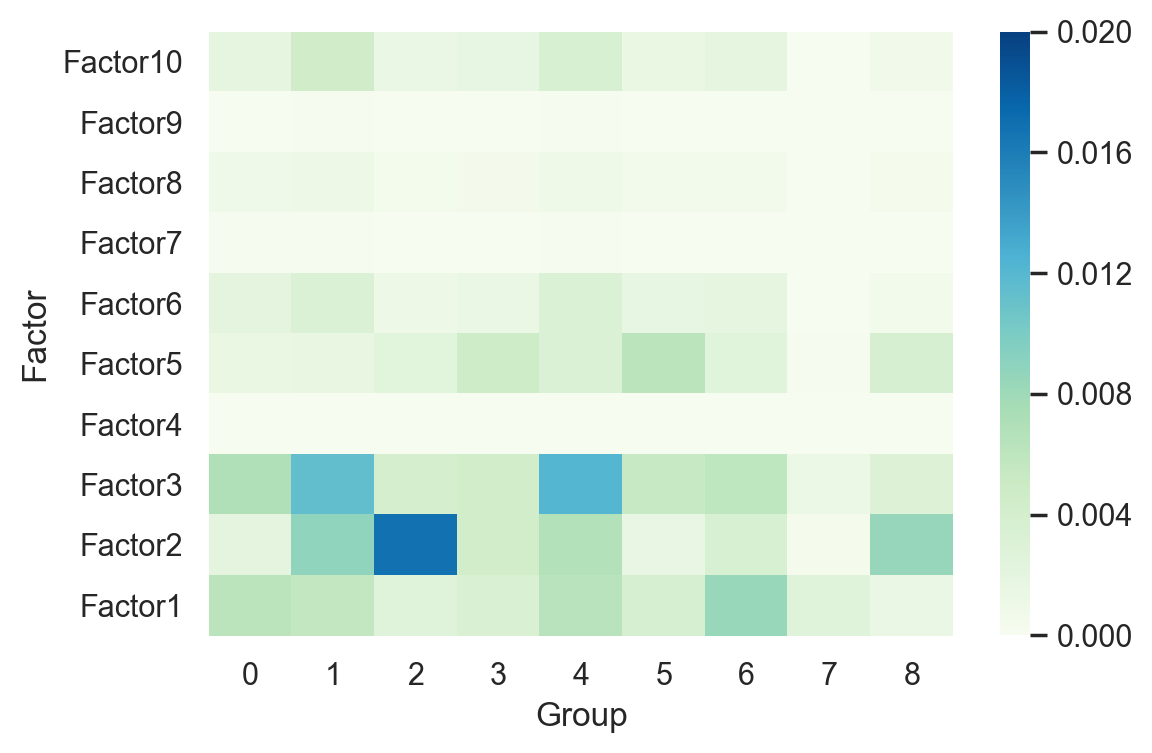

In [21]:
mpp.plot_r2(m, factors=list(range(10)), 
            cmap="GnBu", vmax=.02, vmin=.0)

A barplot can be used in addition to the heatmap to better resolve R2 values for particular factors:

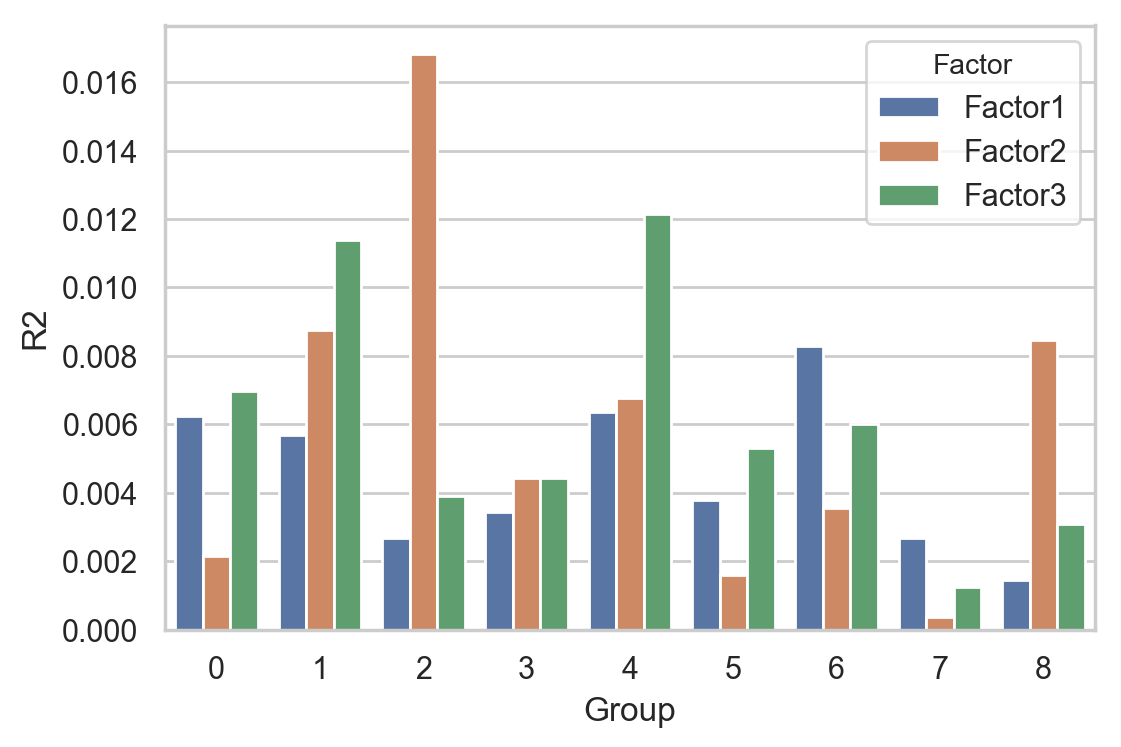

In [22]:
mpp.plot_r2_barplot(m, factors=list(range(3)), x="Group", groupby="Factor")

Slightly more advanced usage includes providing a **custrom grouping** of cells so that R2 values are calculated for new groups and **permutation test** to calculate and plot empirical p-values using re-shuffled group labels instead of R2 values as a heatmap.

# Plotting factors

Factor values describe how prominent a particular process (factor) is for each cell.

Currently the following functions are provided for plottings factor values:

- `plot_factors`,
- `plot_factors_scatter`,
- `plot_factors_matrixplot`.

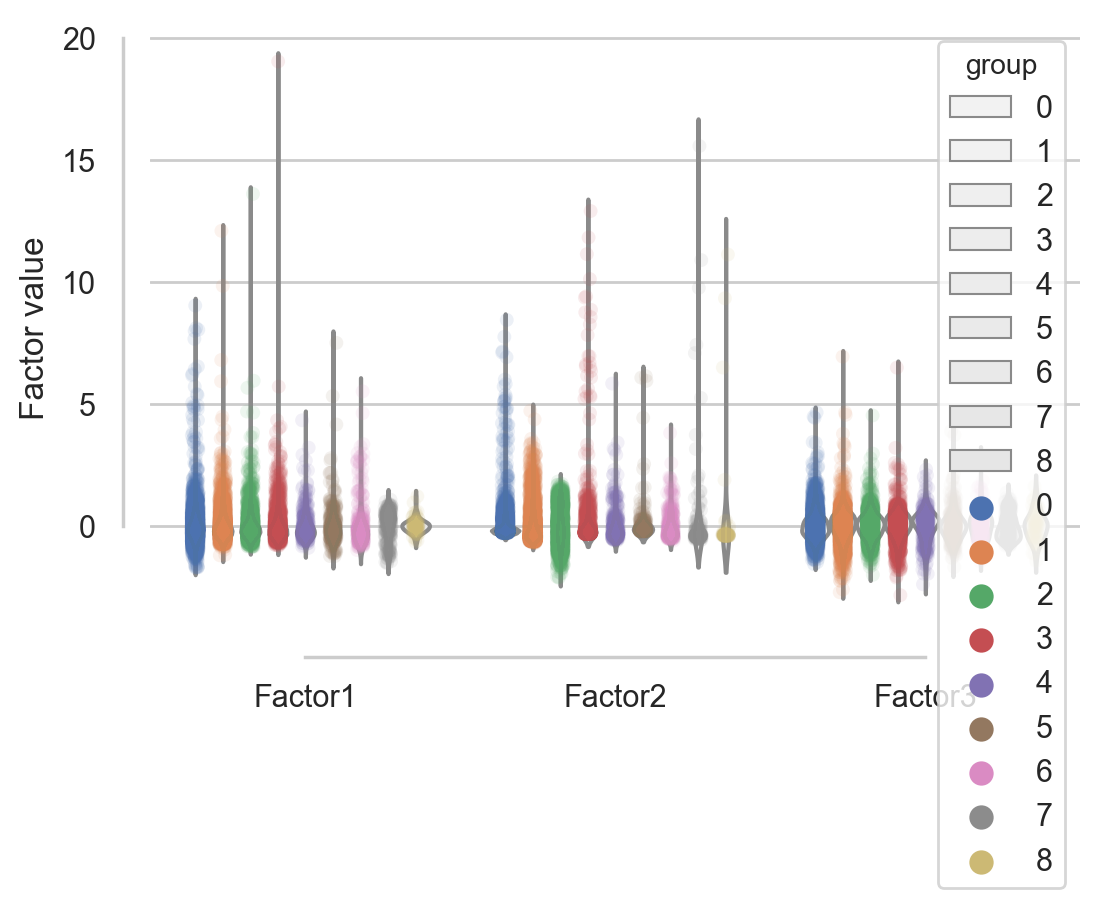

In [23]:
mpp.plot_factors(m, factors=list(range(3)), violin=True, alpha=.1)

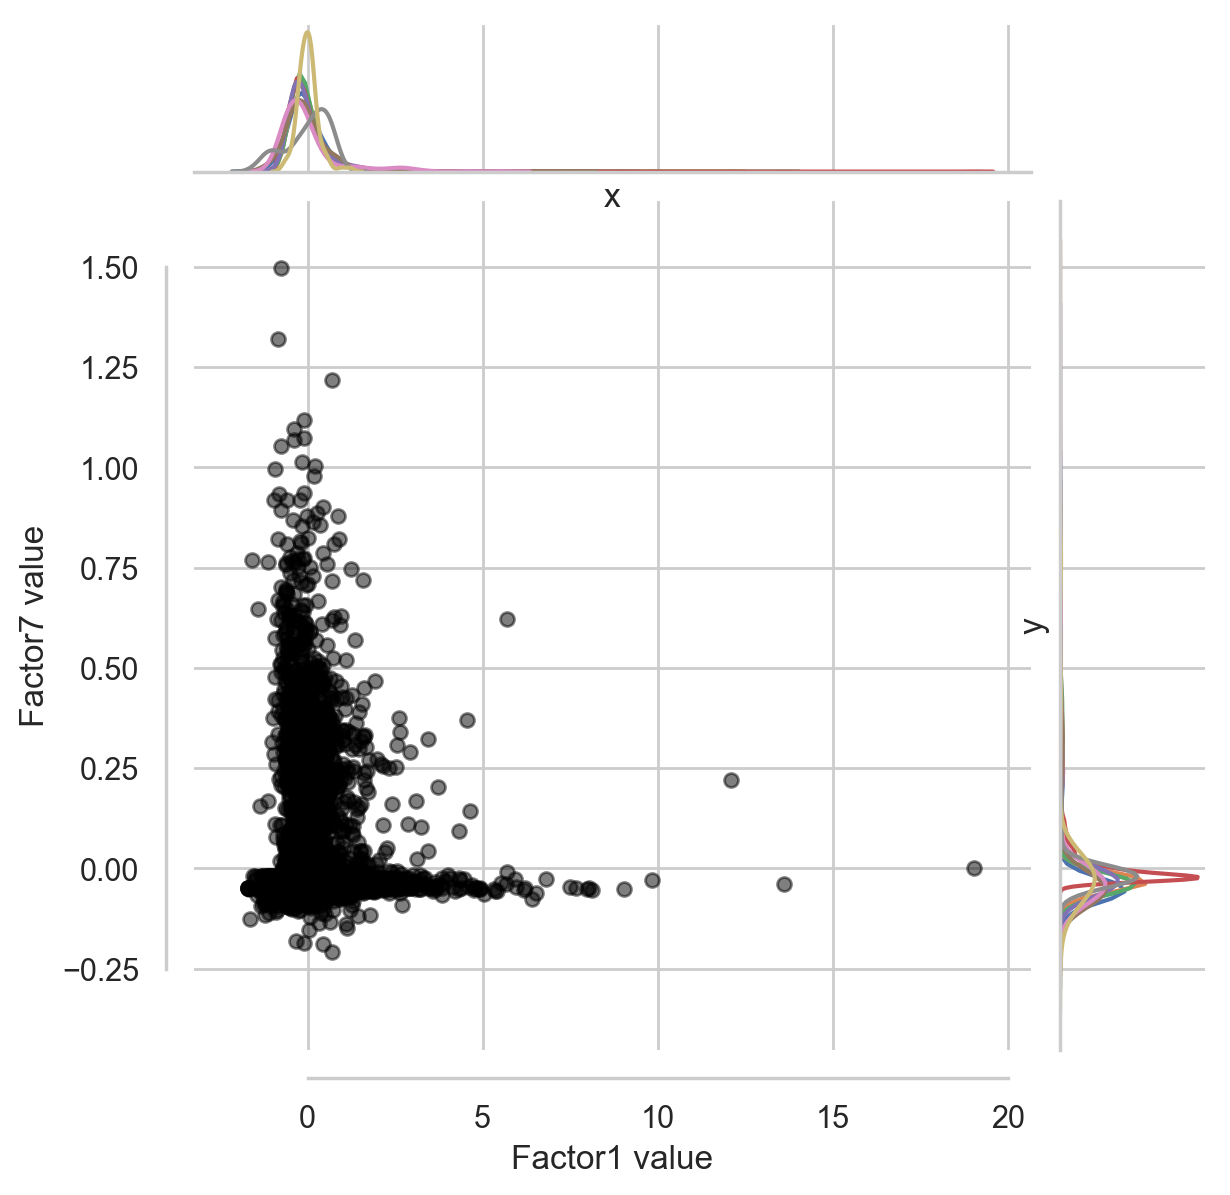

In [24]:
mpp.plot_factors_scatter(m, x="Factor1", y="Factor7", 
                         kde=True,
                         size=5, alpha=.5) 

Multiple factor pairs can be visualised using subplots:

In [25]:
# This is a tricky part: you can't have group labels that can be converted to integers
# when plotting with seaborn. Even if their type is str.
groups_df = m.get_cells().set_index("cell")
groups_df.group = "group_" + groups_df.group.values

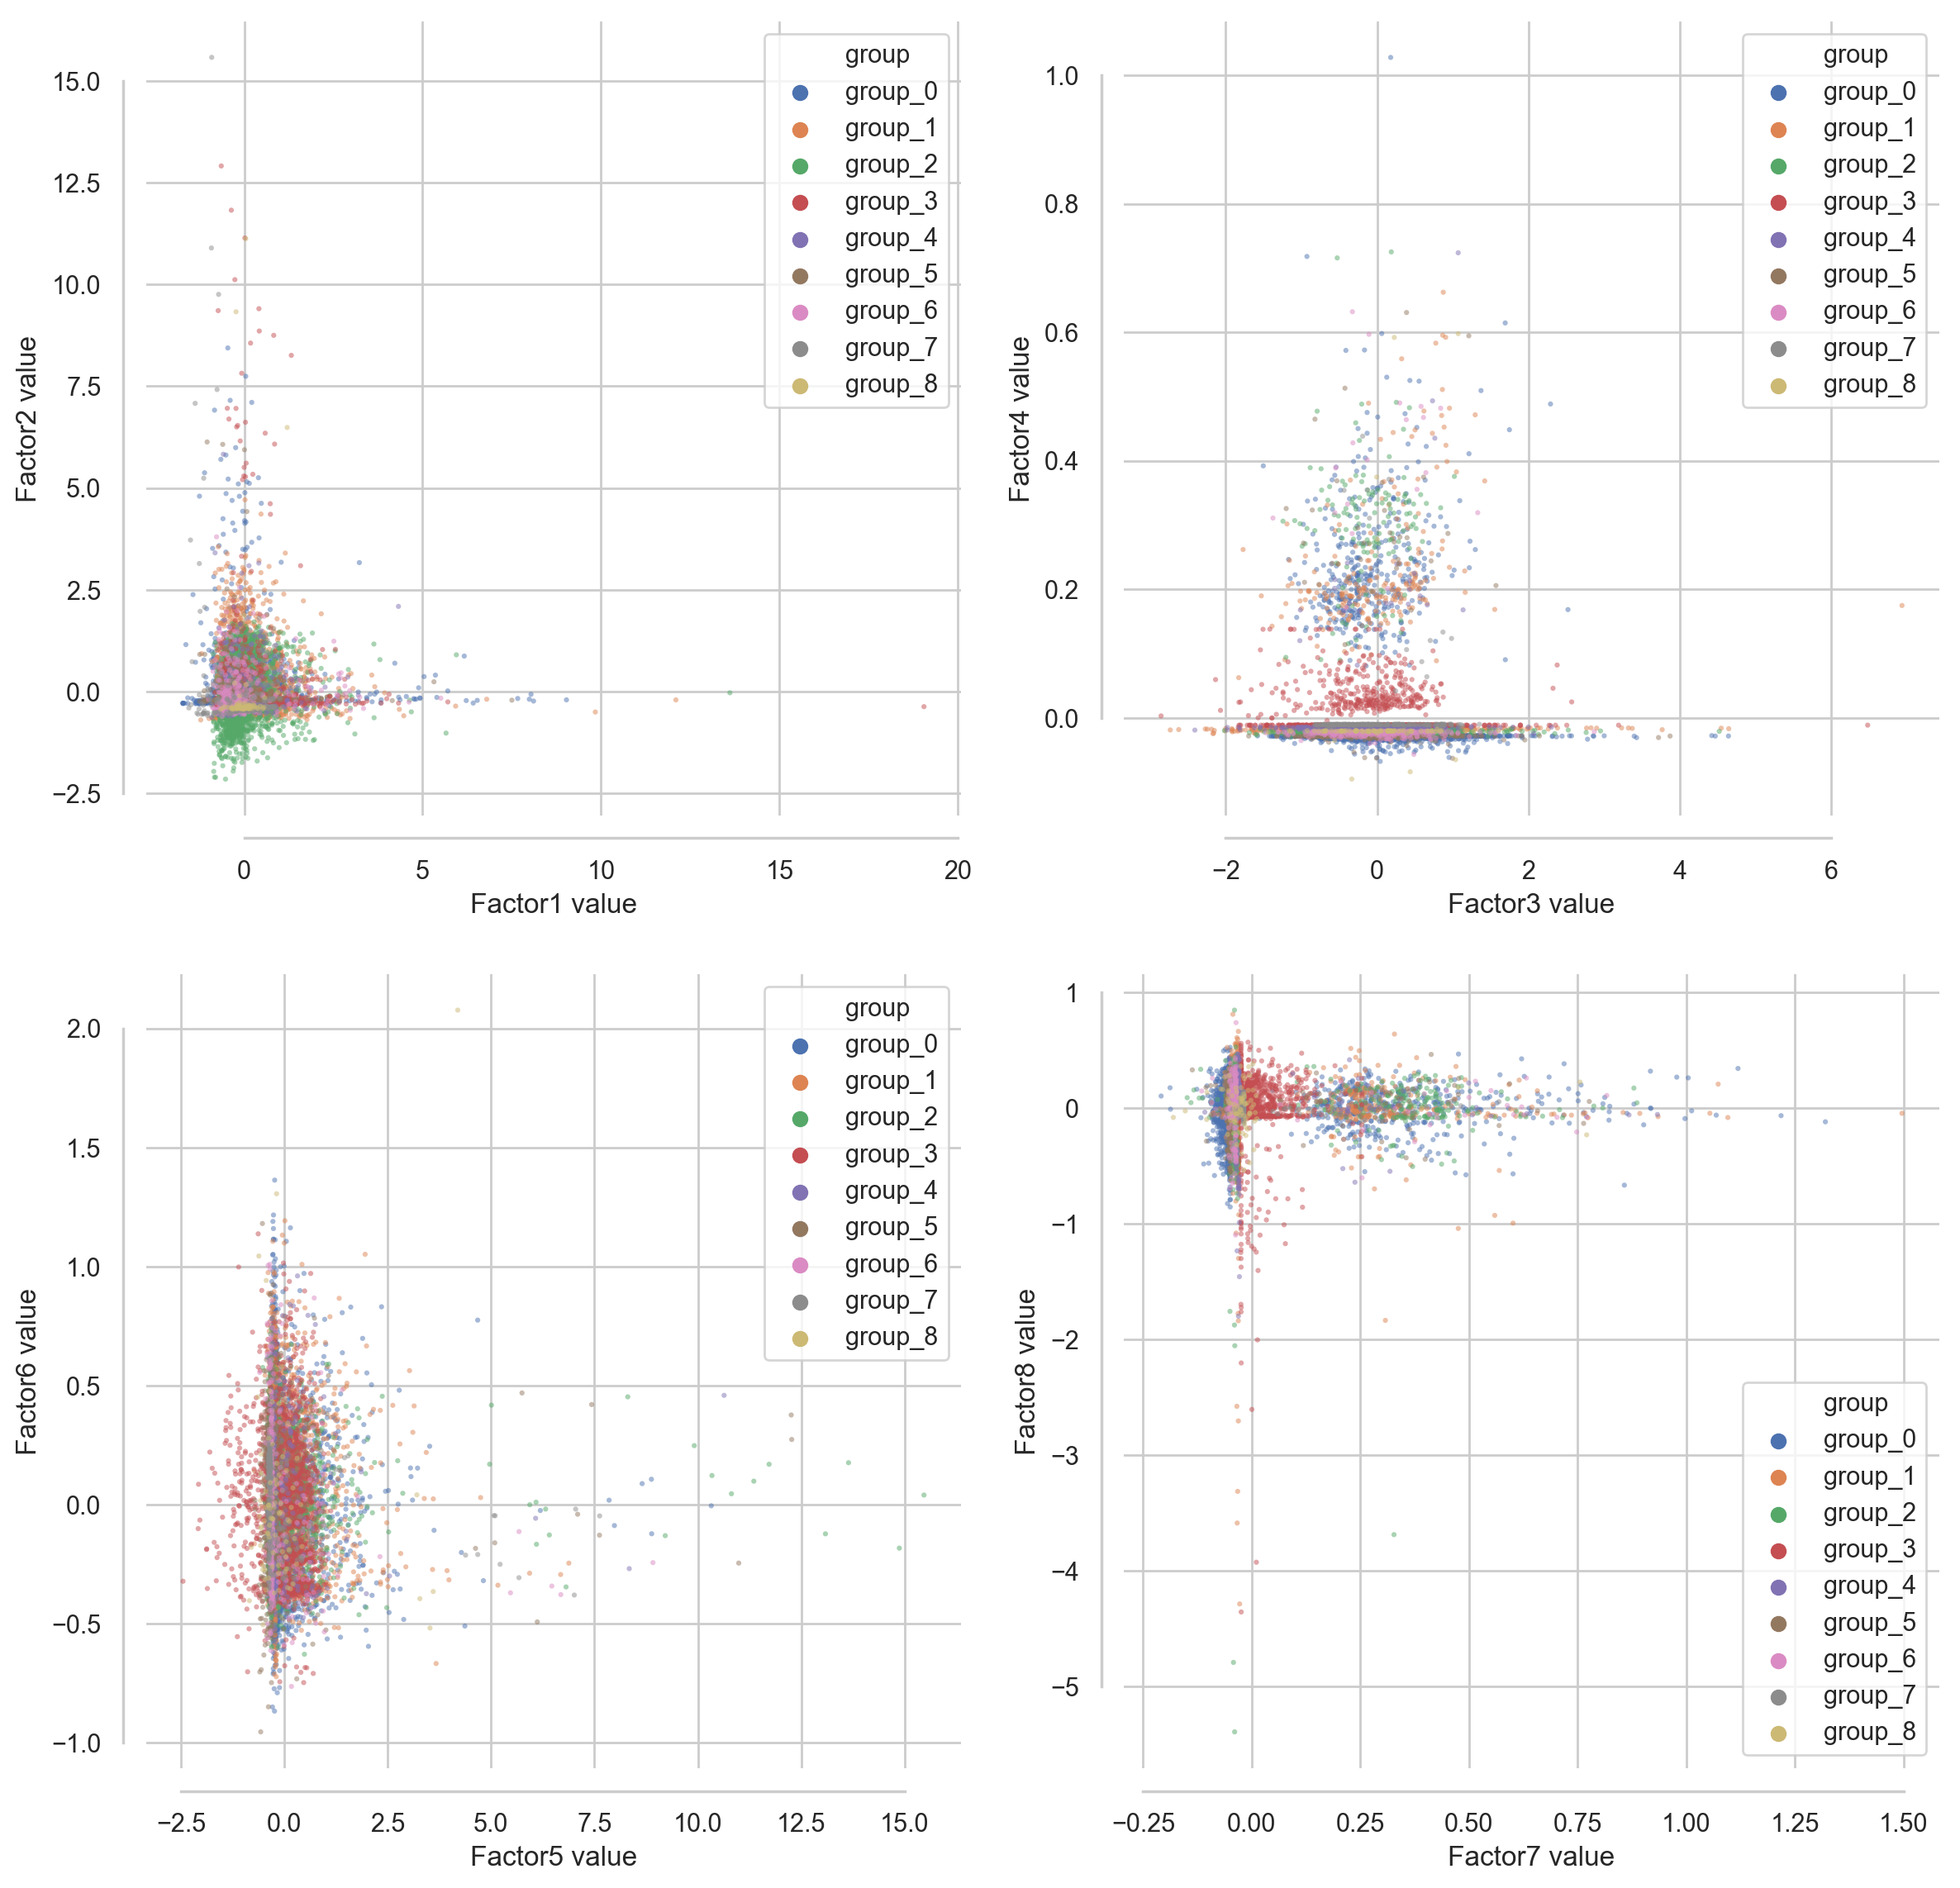

In [26]:
nf = 2  # rows/columns dimensions
f, axarr = plt.subplots(nf, nf, figsize=(14,14))
fnum = 0
for i in range(nf):
    for j in range(nf):
        mpp.plot_factors_scatter(m, x=fnum, y=fnum+1, size=5, alpha=.5, 
                         groups_df=groups_df, 
                         kde=False, hist=False, legend=True, ax=axarr[i][j])
        fnum+=2

Factor values can be aggregated per group and plotted with `plot_factors_matrixplot`.

Aggregation functions accepted by [pandas.DataFrame.agg](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) can be used, e.g.`"mean"` for mean or `"var"` for variance:

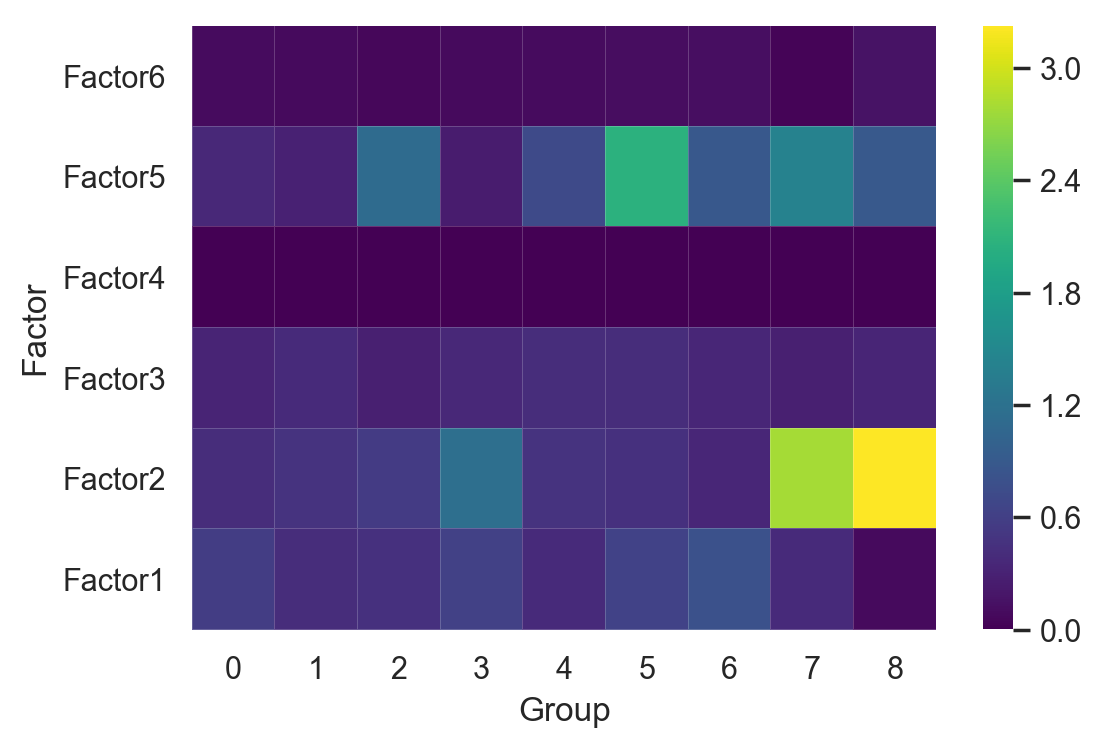

In [30]:
mpp.plot_factors_matrixplot(m, agg="var", factors=list(range(6)), 
                            linewidths=0.01, linecolor="#FFFFFF33")